In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import requests

In [2]:
data = pd.read_csv('../data/SNAP_data_raw.csv')

data["Average Monthly SNAP Benefits per Participant"] = (
    data["Average Monthly SNAP Benefits per Participant"]
    .str.removeprefix("$")
    .replace("N/A", np.nan)
    .astype("float32")
)

data["Average Monthly SNAP Participants"] = (
    data["Average Monthly SNAP Participants"]
    .str.removesuffix(" 1")
    .str.replace(",", "")
    .replace("N/A", np.nan)
    .astype("float32")
)

data["Total Benefits"] = (
    data["Total Benefits"]
    .str.removeprefix("$")
    .str.replace(",", "")
    .str.removesuffix(" 1")
    .replace("N/A", np.nan)
    .astype("int64")
)

data['year'] = data['year'].astype('int16')

data.drop("Unnamed: 0", axis=1, inplace=True)

## Walkability data

Rationale: [Obesity noodle map](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/296290/obesity-map-full-hi-res.pdf)

In [2]:
df_walk = pd.read_csv('../data/walkability.csv')

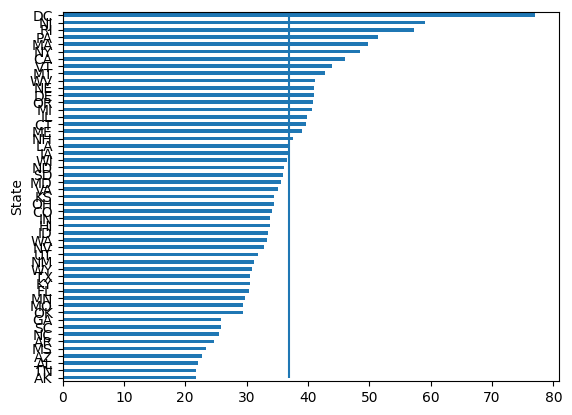

In [3]:
ax = (
    df_walk.groupby('State')['Walk Score'].mean()
    .sort_values(ascending=True)
    .plot
    .barh()
)

ax.vlines(df_walk['Walk Score'].mean(), 0, 1000)

## Activity (CDC) data

In [5]:
df_nutri = pd.read_csv("../data/nutrition_activity.csv")

# YearStart and YearEnd contain the same data
assert (df_nutri['YearEnd'] != df_nutri['YearStart']).sum() == 0

# We give the columns dropped and reasons for dropping
# 1. Data_Value_Unit: Contains all null data
# 2. Total
# 3. Data_Value_Type
# 4. Geolocation: Shape file will be merged externally for choropleth mapping
# 5. YearEnd: Contains the same data as "YearStart"
# 6. Datasource: Contains the same vale: "Youth Risk Behavior Surveillance System"
df_nutri.drop(['Data_Value_Unit', 'Total', 'Data_Value_Type', 'GeoLocation', 'YearEnd', 'Datasource'], axis=1, inplace=True)
df_nutri = df_nutri.query("LocationDesc != 'Guam'")

In [185]:
df_nutri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40096 entries, 0 to 40095
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   40096 non-null  int64  
 1   LocationAbbr                40096 non-null  object 
 2   LocationDesc                40096 non-null  object 
 3   Class                       40096 non-null  object 
 4   Topic                       40096 non-null  object 
 5   Question                    40096 non-null  object 
 6   Data_Value                  29460 non-null  float64
 7   Data_Value_Alt              29460 non-null  float64
 8   Data_Value_Footnote_Symbol  10636 non-null  object 
 9   Data_Value_Footnote         10636 non-null  object 
 10  Low_Confidence_Limit        29460 non-null  float64
 11  High_Confidence_Limit       29460 non-null  float64
 12  Sample_Size                 29460 non-null  float64
 13  Gender                      572

In [7]:
df_nutri.head()

,YearStart,LocationAbbr,LocationDesc,Class,Topic,Question,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,...,Race/Ethnicity,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2019,AK,Alaska,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,9.6,9.6,NaN,NaN,...,Asian,PA,PA1,Q048,VALUE,2,Race/Ethnicity,Asian,RACE,RACEASN
1,2019,AZ,Arizona,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,13.3,13.3,NaN,NaN,...,NaN,OWS,OWS1,Q038,VALUE,4,Total,Total,OVR,OVERALL
2,2019,DC,District of Columbia,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,17.1,17.1,NaN,NaN,...,NaN,OWS,OWS1,Q038,VALUE,11,Total,Total,OVR,OVERALL
3,2019,IL,Illinois,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who partici...,65.9,65.9,NaN,NaN,...,NaN,PA,PA1,Q049,VALUE,17,Grade,10th,GRADE,GRADE10
4,2019,MD,Maryland,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have an...,16.7,16.7,NaN,NaN,...,2 or more races,OWS,OWS1,Q039,VALUE,24,Race/Ethnicity,2 or more races,RACE,RACE2PLUS


Unique question in the dataset: 

|    | ClassID   | QuestionID   | Question                                                                                                                    |
|---:|:----------|:-------------|:----------------------------------------------------------------------------------------------------------------------------|
|  0 | FV        | Q020         | Percent of students in grades 9-12 who consume fruit less than 1 time daily                                                 |
|  1 | FV        | Q021         | Percent of students in grades 9-12 who consume vegetables less than 1 time daily                                            |
|  2 | OWS       | Q038         | Percent of students in grades 9-12 who have obesity                                                                         |
|  3 | OWS       | Q039         | Percent of students in grades 9-12 who have an overweight classification                                                    |
|  4 | PA        | Q048         | Percent of students in grades 9-12 who achieve 1 hour or more of moderate-and/or vigorous-intensity physical activity daily |
|  5 | PA        | Q049         | Percent of students in grades 9-12 who participate in daily physical education                                              |
|  6 | SD        | Q058         | Percent of students in grades 9-12 who drank regular soda/pop at least one time per day                                     |
|  7 | TV        | Q059         | Percent of students in grades 9-12 watching 3 or more hours of television each school day                                   |

(table generated with code: 
```python
print(df_nutri.groupby(["ClassID", "QuestionID"])["Question"]
      .unique()
      .reset_index()
      .explode("Question")
      .to_markdown())
```
)

ClassID: 
- FV: Fruit and vegetables
- OWS: Obesity and Weight Status
- PA: Physical activity
- SD: Soda drink consumption
- TV: TV watching behavior

In [9]:
vegetable_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'FV'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

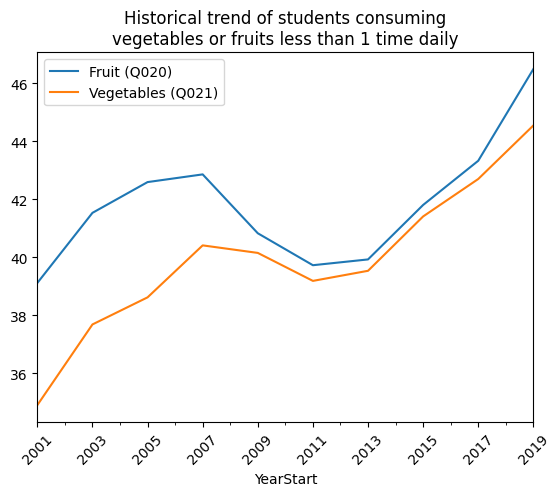

In [10]:
register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = vegetable_trend.plot.line(x='YearStart')
ax.set_title("Historical trend of students consuming\nvegetables or fruits less than 1 time daily")
xticks = pd.date_range(start=vegetable_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text('Fruit (Q020)')
L.get_texts()[1].set_text('Vegetables (Q021)')

In [11]:
pd.pivot_table(
        df_nutri.query("ClassID == 'FV'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )

QuestionID,Q020,Q021
YearStart,,
2001,39.120603,34.909091
2003,41.536934,37.689606
2005,42.597326,38.623562
2007,42.862774,40.415365
2009,40.833095,40.155643
2011,39.731448,39.191022
2013,39.931068,39.539080
2015,41.808837,41.412698
2017,43.332045,42.703590


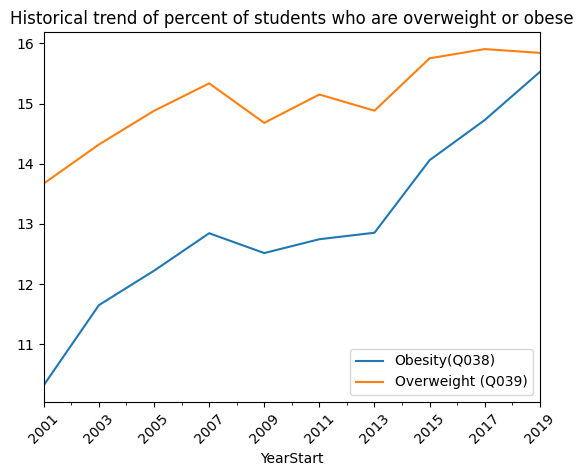

In [12]:
obesity_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'OWS'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = obesity_trend.plot.line(x='YearStart')
ax.set_title("Historical trend of percent of students who are overweight or obese")
xticks = pd.date_range(start=vegetable_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text('Obesity(Q038)')
L.get_texts()[1].set_text('Overweight (Q039)')

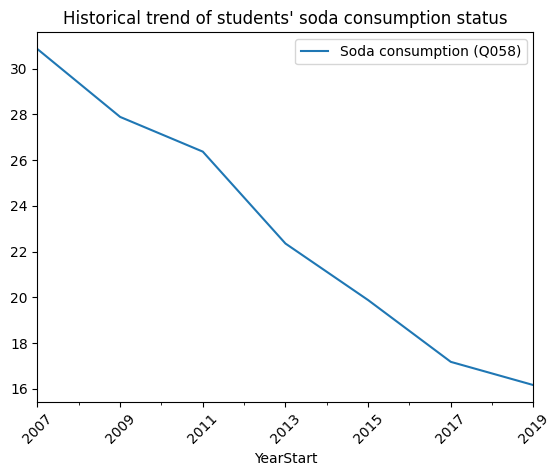

In [13]:
soda_trend = (
    pd.pivot_table(
        df_nutri.query("ClassID == 'SD'"),
        index="YearStart",
        columns="QuestionID",
        values="Data_Value",
    )
    .reset_index()
    .assign(YearStart = lambda x: pd.to_datetime(x["YearStart"], format="%Y"))
)

register_matplotlib_converters()  # This is needed for pandas datetime

# Plotting
ax = soda_trend.plot.line(x='YearStart')
ax.set_title("Historical trend of students' soda consumption status")
xticks = pd.date_range(start=soda_trend['YearStart'].min(), end="2020-01-01", freq='2Y')
ax.set_xticks(xticks)
ax.set_xticklabels([x.strftime('%Y') for x in xticks], rotation=45)
L = plt.legend()
L.get_texts()[0].set_text('Soda consumption (Q058)')

In [14]:
df_nutri.head(5)

,YearStart,LocationAbbr,LocationDesc,Class,Topic,Question,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,...,Race/Ethnicity,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2019,AK,Alaska,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,9.6,9.6,NaN,NaN,...,Asian,PA,PA1,Q048,VALUE,2,Race/Ethnicity,Asian,RACE,RACEASN
1,2019,AZ,Arizona,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,13.3,13.3,NaN,NaN,...,NaN,OWS,OWS1,Q038,VALUE,4,Total,Total,OVR,OVERALL
2,2019,DC,District of Columbia,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,17.1,17.1,NaN,NaN,...,NaN,OWS,OWS1,Q038,VALUE,11,Total,Total,OVR,OVERALL
3,2019,IL,Illinois,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who partici...,65.9,65.9,NaN,NaN,...,NaN,PA,PA1,Q049,VALUE,17,Grade,10th,GRADE,GRADE10
4,2019,MD,Maryland,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have an...,16.7,16.7,NaN,NaN,...,2 or more races,OWS,OWS1,Q039,VALUE,24,Race/Ethnicity,2 or more races,RACE,RACE2PLUS


In [187]:
walk_physical = (
    df_nutri.query("YearStart == 2019 & QuestionID == 'Q048' & Stratification1 == 'Total'")
    .merge(
        (
            df_walk[['State', 'Walk Score', 'Bike Score']]
            .groupby('State')[['Walk Score', 'Bike Score']]
            .mean()
        ), 
        how = "inner",
        left_on = "LocationAbbr",
        right_on = "State"
    )
)

walk_physical.head(3)

,YearStart,LocationAbbr,LocationDesc,Class,Topic,Question,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,...,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1,Walk Score,Bike Score
0,2019,TX,Texas,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,22.9,22.9,NaN,NaN,...,PA1,Q048,VALUE,48,Total,Total,OVR,OVERALL,30.575949,38.031646
1,2019,RI,Rhode Island,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,21.1,21.1,NaN,NaN,...,PA1,Q048,VALUE,44,Total,Total,OVR,OVERALL,57.333333,45.222222
2,2019,MS,Mississippi,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,23.4,23.4,NaN,NaN,...,PA1,Q048,VALUE,28,Total,Total,OVR,OVERALL,23.375000,33.583333


In [200]:
calc_people = lambda x, y: x * y
# todo: availability of parks? 
smf.ols("calc_people(Q('Sample_Size'), Q('Data_Value')) ~ Q('Walk Score') + Q('Bike Score')", data = walk_physical).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     calc_people(Q('Sample_Size'), Q('Data_Value'))   R-squared:                       0.044
Model:                                                        OLS   Adj. R-squared:                  0.022
Method:                                             Least Squares   F-statistic:                     1.974
Date:                                            Thu, 30 Nov 2023   Prob (F-statistic):              0.167
Time:                                                    14:24:31   Log-Likelihood:                -541.45
No. Observations:                                              45   AIC:                             1087.
Df Residuals:                                                  43   BIC:                             1091.
Df Model:                                                       1                                         
Covariance Type:                                        nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.021e+04   2.19e+04      1.379      0.175    -1.4e+04    7.44e+04
Q('Walk Score')   810.5514    576.944      1.405      0.167    -352.968    1974.071
==============================================================================
Omnibus:                       22.338   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.325
Skew:                           1.659   Prob(JB):                     1.58e-07
Kurtosis:                       5.387   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='Walk Score', ylabel='Data_Value'>

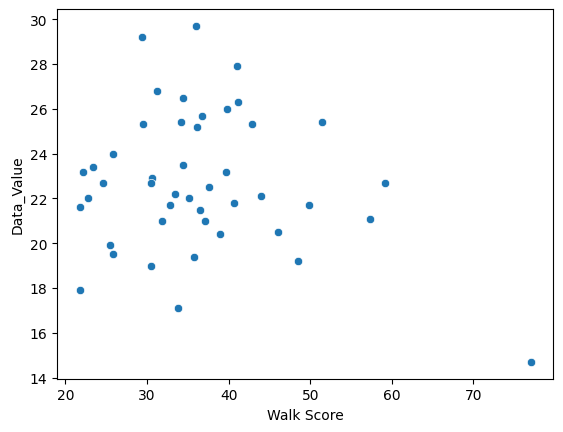

In [193]:
sns.scatterplot(data = walk_physical,
                x = "Walk Score",
                y = "Data_Value",)